# Brownian motion simulation, correlation and fitting using python, end-to-end.
By Dominic Waithe (2017)

2-D brownian motion simulation of molecules in square simulation area. 
The simulation is performed using numpy functions (fast).
The correlation is performed using padded array and fourier domain (fast).
The fitting uses lmfit library (v.good).

Dependencies:
- numpy, scipy, matplotlib
- The fitting is performed using the lmfit library (lmfit 0.9.5)

Assumptions:
- Molecules wrap around boundary when crossing. 
- Detection volume is simulated as a Gaussian.


In [25]:
#Dependencies
%pylab inline
from __future__ import division
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
import copy
from lmfit import minimize, Parameters,report_fit,report_errors, fit_report

#Functions for simulation
def calculate_psf(psfs,distance):
    # calculate excitation psf
    psf = {}
    psf['FWHMs'] = psfs
    psf['pixel_size'] = 1.0;
    psf['ri'] = np.meshgrid(np.arange(0,distance,psf['pixel_size']))[0];

    psf['number_FWHMs'] = psf['FWHMs'].__len__()
    psf['V'] = {}
    for ki in range(0, psf['number_FWHMs']):
        psf['V'][ki] = 2.0**(- psf['ri']**2 / (psf['FWHMs'][ki]/2.0)**2); #Gaussian distribution
    return psf

def brownian_only_numpy(total_sim_time,time_step,num_of_mol,D, width, height):
    """

    Inputs:
    total_simulation_time: Total simulation time in ms.
    time_step:             The duration of each time step ms.
    num_mol:               The number of molecules in the simulation.
    D:                     The diffusion rate.
    width:                 The width of the simulation.
    height:                The height of the simulation.
    Outputs:
    track_arr:             A dictionary where each track number (e.g. track_arr[0]) contains the track data [0,:] [1,:]
    """
   
    
    # Number of steps.
    num_of_steps = int(round(float(total_sim_time)/float(time_step),0))

    print 'num_of_steps',num_of_steps
    # Calculates length scales
    scale_in = np.sqrt(2.0 * (float(D)*1e3) * float(time_step))

    #Randomly generates start locations
    start_coord_x = (np.random.uniform(0.0, 1.0, num_of_mol))*width
    start_coord_y = (np.random.uniform(0.0, 1.0, num_of_mol))*height

    track_arr = {}
    
    
    #This can be done as one big matrix, but can crash system if large so I break it up into the individual molecules.
    for b in range(0,num_of_mol):
        print 'processing tracks: ',np.round((float(b)/float(num_of_mol))*100,1),'%'
        track_arr[b] = np.zeros((2,num_of_steps))
        track_arr[b][0,0] = start_coord_y[b]
        track_arr[b][1,0] = start_coord_x[b]
        rand_in  = norm.rvs(size=[2,num_of_steps])*scale_in
        track_arr[b][:,1:] += rand_in[:,1:]
        track_arr[b] = np.cumsum(track_arr[b],1)
        out = track_arr[b]
        mod = np.zeros((out.shape))
        mod[0,:] = np.floor(track_arr[b][0,:].astype(np.float64)/height)
        mod[1,:] = np.floor(track_arr[b][1,:].astype(np.float64)/width)
        track_arr[b] = np.array(out-([mod[0,:]*height,mod[1,:]*width]))
        
    

    return track_arr
def integrate_over_psf(psf,track_arr,num_of_mol,psy,psx):
    #Pass each molecule through the psf function.
    psf['trace'] ={}
    sys.stdout.write('\n')
    for ki in range(0, psf['number_FWHMs']):
        sys.stdout.write('\r')
        sys.stdout.write("processing FWHM %d" % psf['FWHMs'][ki])
        sys.stdout.flush()
        trace = 0
        for b in range(0,num_of_mol):
            trace += psf['V'][ki][np.round(np.sqrt((track_arr[b][1]-psx)**2+(track_arr[b][0]-psy)**2),0).astype(np.int32)]
        psf['trace'][ki] = copy.deepcopy(trace)
    return psf



## Simulation script

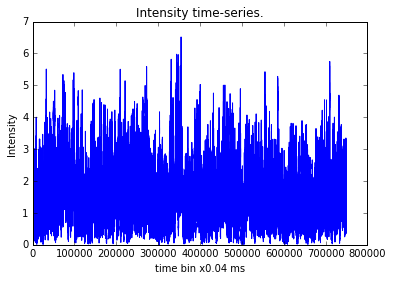

In [26]:
#This line makes the output print to the terminal.
sys.stdout = open('/dev/stdout', 'w')



width = 3000.0 #The width of the simulation.
height = 3000.0 #The height of the simulation. Should be greater than the active area radius.
total_sim_time = 30000 # Total time. ms
num_of_mol = 200 #Number of molecules in simulation.
time_step = 0.04 #Time step in ms.
D = 1.0 #diffusion coefficient [um^2/s]




foci_to_generate = np.array([250.0]) #FWHM in nm for the foci detection.

#generates psf.
size = max(width,height)
psf = calculate_psf(foci_to_generate,size) 

#Simulates the brownian motion.
track_arr = brownian_only_numpy(total_sim_time,time_step,num_of_mol,D, width,height)
                

psx = height//2
psy = width//2

psf = integrate_over_psf(psf,track_arr,num_of_mol,psy,psx)

intensity_profile = psf['trace'][0]

plot(intensity_profile)
title("Intensity time-series.")
ylabel("Intensity" )
xlabel("time bin (x"+str(time_step)+" ms)" )

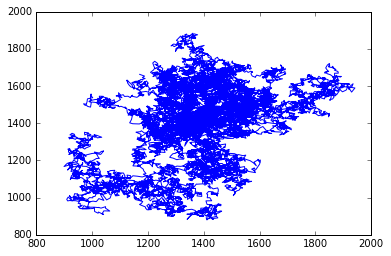

In [12]:
#Optional plot the tracks of one of the molecules. Can be very slow if too much time plotted.
#plot(track_arr[0][0,:15000],track_arr[1][0,0:15000])

## Auto-correlation functions

In [28]:
def correlate_linear(a, b):
    """Return linear correlation of two vectors using DFT."""
    size = a.shape[0]
    
    # subtract mean and pad with zeros to twice the size
    a_mean = np.average(a)
    b_mean = np.average(b)
    
    #Has the padding in
    a = numpy.pad(a-a_mean, a.size//2, mode='constant')
    b = numpy.pad(b-b_mean, b.size//2, mode='constant')
    
    # forward DFT
    a = numpy.fft.rfft(a)
    b = numpy.fft.rfft(b)
    # multiply by complex conjugate
    c = a * b.conj()
    # reverse DFT
    c = numpy.fft.irfft(c)
    # positive delays only
    c = c[:size // 2]
        
    # normalize with the averages of a and b
    c /= size * a_mean * b_mean
    
    return np.array(c)
def binaver(c, bins):
    """Return averaged chunks of vector."""
    out = [numpy.average(c[:bins[0]])]
    for i in range(len(bins)-1):
        out.append(numpy.mean(c[bins[i]:bins[i+1]]))
    return np.array(out)


def logbins(size, nbins):
    """Return up to nbins exponentially increasing integers from 1 to size."""
    b = numpy.logspace(0, math.log(size, 2), nbins, base=2, endpoint=True)
    return numpy.unique(b.astype('intp'))


def smooth(c):
    """Return double exponentially smoothed vector."""
    out = c.copy()
    out[0] = out[1]
    for i in range(1, len(out)):
        out[i] = out[i] * 0.3 + out[i-1] * 0.7
    for i in range(len(out)-2, -1, -1):
        out[i] = out[i] * 0.3 + out[i+1] * 0.7
    return np.array(out)


# Auto-correlation script

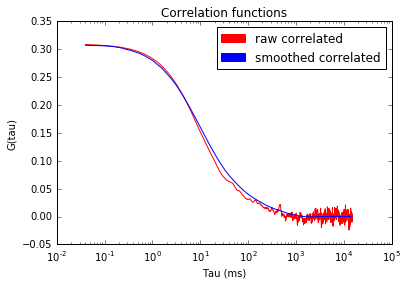

In [49]:
a = np.array(intensity_profile)
b = np.array(intensity_profile)

print 'fft correlation but zero padded to be linear (RED)'
corr = correlate_linear(a,b)#correlate linear
#Calculates smoothed version of curve using logarithmic bins.
bins = logbins(a.size//2, 64)
scorr = smooth(binaver(corr,bins))
time = bins*time_step

#Plotting
title("Correlation functions")
ylabel('G(tau)')
xlabel('Tau (ms)')
semilogx(np.arange(0,a.shape[0]//2)*time_step,corr,'r')
red_patch = matplotlib.patches.Patch(color='red', label='raw correlated')
blue_patch = matplotlib.patches.Patch(color='blue', label='smoothed correlated')
plt.legend(handles=[red_patch,blue_patch])
semilogx(time,scorr,'b')


## Fitting functions

In [30]:
def residual(param, x, data):
    A = equation_(param, x)
    residuals = np.array(data)-np.array(A)
    return np.array(residuals).astype(np.float64)
def equation_(param, tc):
    """This is equation for fitting"""
    

    #A1 is relative component of fluorescent species
    #tc is tau.
    #txy1 is xy difusion   for fluorescent species one.
    #alpha1 is
    #tz1 is z diffusion for fluorescent species one.
    offset =param['offset'].value; 
    GN0 =param['GN0'].value; 
    A1 = param['A1'].value; txy1 = param['txy1'].value; alpha1 = param['alpha1'].value;
    #For one diffusing species
    GDiff = (A1*(((1+((tc/txy1)**alpha1))**-1)))
    return offset + (GN0*GDiff)

In [31]:

#Paremeters for fitting.
param = Parameters()

param.add('offset', value=0.01, min=-0.5, max=1.5, vary=True);
param.add('GN0', value=1.000, min=-0.0001, max=3000.0, vary=True);
param.add('offset', value=0.01, min=-0.5, max=1.5, vary=True);
param.add('A1', value=1.000, min=0.0001, max=1.0000, vary=False);
param.add('txy1',value=0.10, min=0.001, max=2000.0, vary=True);
param.add('alpha1',value=1.0, min=0.600, max=2.0, vary=False);
options = {'Dimen':1,'Diff_eq':1,'Triplet_eq':1,'Diff_species':1}

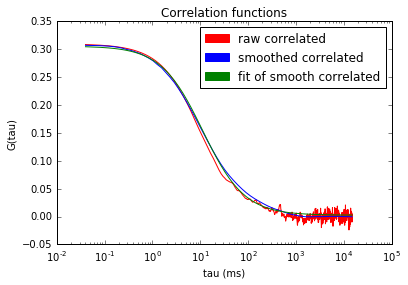

In [46]:
res = minimize(residual, param, args=(time,scorr))
residualVar = res.residual
output = fit_report(res.params)

title("Correlation functions")
semilogx(np.arange(0,a.shape[0]//2)*time_step,corr,'r')
semilogx(time,scorr,'b')
semilogx(time,equation_(res.params,time),'g')
xlabel("tau (ms)")
ylabel("G(tau)")
red_patch = matplotlib.patches.Patch(color='red', label='raw correlated')
blue_patch = matplotlib.patches.Patch(color='blue', label='smoothed correlated')
grn_patch = matplotlib.patches.Patch(color='green', label='fit of smooth correlated')

plt.legend(handles=[red_patch,blue_patch,grn_patch])
#The calculated diffusion time. Should be close to input value (default =1.0). Some error is expected
print ((1.0/np.sqrt(2.0*np.log(2.0)))*float(psf['FWHMs'][0])/1000.0)**2/(4*res.params['txy1'].value)*1000.0,'um/s'